<a href="https://colab.research.google.com/github/thunderhoser/cira_uq4ml/blob/main/mc_dropout_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and define constants

In [ ]:
import numpy
from matplotlib import pyplot
import matplotlib.colors
import shapely.geometry
from descartes import PolygonPatch
from sklearn.metrics import auc as area_under_curve
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, \
    BatchNormalization
from tensorflow import keras as tf_keras
from keras.datasets import mnist

NUM_GRID_ROWS = 28
NUM_GRID_COLUMNS = 28
NUM_MONTE_CARLO_ESTIMATES = 1000

MEAN_PREDICTION_STDEVS_KEY = 'mean_prediction_stdevs'
BIN_EDGE_PREDICTION_STDEVS_KEY = 'bin_edge_prediction_stdevs'
RMSE_VALUES_KEY = 'rmse_values'
EXAMPLE_COUNTS_KEY = 'example_counts'
SPREAD_SKILL_RELIABILITY_KEY = 'spread_skill_reliability'
MEAN_CENTRAL_PREDICTIONS_KEY = 'mean_central_predictions'
MEAN_TARGET_VALUES_KEY = 'mean_target_values'

DISCARD_FRACTIONS_KEY = 'discard_fractions'
ERROR_VALUES_KEY = 'error_values'
EXAMPLE_FRACTIONS_KEY = 'example_fractions'
MONOTONICITY_FRACTION_KEY = 'monotonicity_fraction'

HISTOGRAM_FACE_COLOUR = numpy.full(3, 152. / 255)
HISTOGRAM_EDGE_COLOUR = numpy.full(3, 0.)
HISTOGRAM_EDGE_WIDTH = 2.

MEAN_PREDICTION_LINE_COLOUR = numpy.array([117, 112, 179], dtype=float) / 255
MEAN_PREDICTION_COLOUR_STRING = 'purple'
MEAN_TARGET_LINE_COLOUR = numpy.array([27, 158, 119], dtype=float) / 255
MEAN_TARGET_COLOUR_STRING = 'green'

REFERENCE_LINE_COLOUR = numpy.full(3, 152. / 255)
REFERENCE_LINE_WIDTH = 2.

SPREAD_SKILL_COLOUR = numpy.array([217, 95, 2], dtype=float) / 255
SPREAD_SKILL_LINE_WIDTH = 3.
SPREAD_SKILL_MARKER_TYPE = 'o'
SPREAD_SKILL_MARKER_SIZE = 12

DISCARD_TEST_COLOUR = numpy.array([217, 95, 2], dtype=float) / 255
DISCARD_TEST_LINE_WIDTH = 3.
DISCARD_TEST_MARKER_TYPE = 'o'
DISCARD_TEST_MARKER_SIZE = 12

LEVELS_FOR_PEIRCE_CONTOURS = numpy.linspace(0, 1, num=11, dtype=float)
ROC_CURVE_COLOUR = numpy.array([228, 26, 28], dtype=float) / 255
ROC_CURVE_WIDTH = 3.

LEVELS_FOR_CSI_CONTOURS = numpy.linspace(0, 1, num=11, dtype=float)
LEVELS_FOR_BIAS_CONTOURS = numpy.array([0.25, 0.5, 0.75, 1, 1.5, 2, 3, 5])
PERF_DIAGRAM_COLOUR = numpy.array([228, 26, 28], dtype=float) / 255
PERF_DIAGRAM_LINE_WIDTH = 3.

FREQUENCY_BIAS_COLOUR = numpy.full(3, 152. / 255)
FREQUENCY_BIAS_LINE_WIDTH = 2
FREQUENCY_BIAS_STRING_FORMAT = '%.2f'
FREQUENCY_BIAS_LABEL_PADDING_PX = 10

RELIABILITY_COLOUR = numpy.array([228, 26, 28], dtype=float) / 255
RELIABILITY_LINE_WIDTH = 3

NO_SKILL_LINE_COLOUR = numpy.array([31, 120, 180], dtype=float) / 255
NO_SKILL_LINE_WIDTH = 2
SKILL_AREA_TRANSPARENCY = 0.2

ATTRIBUTES_DIAG_HIST_FACE_COLOUR = numpy.array([228, 26, 28], dtype=float) / 255
ATTRIBUTES_DIAG_HIST_EDGE_COLOUR = numpy.full(3, 0.)
ATTRIBUTES_DIAG_HIST_EDGE_WIDTH = 2

ATTRIBUTES_DIAG_HIST_Y_SPACING = 0.1
ATTRIBUTES_DIAG_HIST_X_TICKS = numpy.linspace(0, 1, num=6, dtype=float)

FONT_SIZE = 30
INSET_FONT_SIZE = 16

pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

# Define private methods

If a method's name begins with an underscore, it is private.  Private methods should be called only by other methods, never directly by the user.

In [ ]:
def _plot_means_as_inset(
        figure_object, bin_centers, bin_mean_predictions,
        bin_mean_target_values, for_spread_skill_plot):
    """Plots means (mean prediction and target by bin) as inset in another fig.

    B = number of bins

    :param figure_object: Will plot as inset in this figure (instance of
        `matplotlib.figure.Figure`).
    :param bin_centers: length-B numpy array with value at center of each bin.
        These values will be plotted on the x-axis.
    :param bin_mean_predictions: length-B numpy array with mean prediction in
        each bin.  These values will be plotted on the y-axis.
    :param bin_mean_target_values: length-B numpy array with mean target value
        (event frequency) in each bin.  These values will be plotted on the
        y-axis.
    :param for_spread_skill_plot: Boolean flag.
    :return: inset_axes_object: Axes handle for histogram (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    """

    if for_spread_skill_plot:
        inset_axes_object = figure_object.add_axes([0.625, 0.3, 0.25, 0.25])
    else:
        inset_axes_object = figure_object.add_axes([0.625, 0.55, 0.25, 0.25])

    target_handle = inset_axes_object.plot(
        bin_centers, bin_mean_target_values, color=MEAN_TARGET_LINE_COLOUR,
        linestyle='solid', linewidth=2,
        marker='o', markersize=8, markeredgewidth=0,
        markerfacecolor=MEAN_TARGET_LINE_COLOUR,
        markeredgecolor=MEAN_TARGET_LINE_COLOUR
    )[0]

    prediction_handle = inset_axes_object.plot(
        bin_centers, bin_mean_predictions, color=MEAN_PREDICTION_LINE_COLOUR,
        linestyle='dashed', linewidth=2,
        marker='o', markersize=8, markeredgewidth=0,
        markerfacecolor=MEAN_PREDICTION_LINE_COLOUR,
        markeredgecolor=MEAN_PREDICTION_LINE_COLOUR
    )[0]

    y_max = max([
        numpy.nanmax(bin_mean_predictions),
        numpy.nanmax(bin_mean_target_values)
    ])
    inset_axes_object.set_ylim(0, y_max)
    inset_axes_object.set_xlim(left=0.)

    for this_tick_object in inset_axes_object.xaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(INSET_FONT_SIZE)
        this_tick_object.label.set_rotation('vertical')

    for this_tick_object in inset_axes_object.yaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(INSET_FONT_SIZE)

    inset_axes_object.legend(
        [target_handle, prediction_handle],
        ['Mean target', 'Mean prediction'],
        loc='upper center', bbox_to_anchor=(0.5, -0.2),
        fancybox=True, shadow=True, ncol=1, fontsize=INSET_FONT_SIZE
    )

    return inset_axes_object


def _plot_histogram(axes_object, bin_edges, bin_frequencies):
    """Plots histogram on existing axes.

    B = number of bins

    :param axes_object: Will plot histogram on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param bin_centers: length-(B + 1) numpy array with values at edges of each
        bin. These values will be plotted on the x-axis.
    :param bin_frequencies: length-B numpy array with fraction of examples in
        each bin. These values will be plotted on the y-axis.
    :return: histogram_axes_object: Axes handle for histogram only (also
        instance of `matplotlib.axes._subplots.AxesSubplot`).
    """

    histogram_axes_object = axes_object.twinx()
    axes_object.set_zorder(histogram_axes_object.get_zorder() + 1)
    axes_object.patch.set_visible(False)

    histogram_axes_object.bar(
        x=bin_edges[:-1], height=bin_frequencies, width=numpy.diff(bin_edges),
        color=HISTOGRAM_FACE_COLOUR, edgecolor=HISTOGRAM_EDGE_COLOUR,
        linewidth=HISTOGRAM_EDGE_WIDTH, align='edge'
    )

    return histogram_axes_object


def _log2(input_array):
    """Computes logarithm in base 2.

    :param input_array: numpy array.
    :return: logarithm_array: numpy array with the same shape as `input_array`.
    """

    return numpy.log2(numpy.maximum(input_array, 1e-6))


def _get_pofd_pod_grid(pofd_spacing=0.01, pod_spacing=0.01):
    """Creates grid in POFD-POD space.

    POD = probability of detection
    POFD = probability of false detection

    M = number of rows (unique POD values) in grid
    N = number of columns (unique POFD values) in grid

    :param pofd_spacing: Spacing between grid cells in adjacent columns.
    :param pod_spacing: Spacing between grid cells in adjacent rows.
    :return: pofd_matrix: M-by-N numpy array of POFD values.
    :return: pod_matrix: M-by-N numpy array of POD values.
    """

    num_pofd_values = 1 + int(numpy.ceil(1. / pofd_spacing))
    num_pod_values = 1 + int(numpy.ceil(1. / pod_spacing))

    unique_pofd_values = numpy.linspace(0., 1., num=num_pofd_values)
    unique_pod_values = numpy.linspace(0., 1., num=num_pod_values)[::-1]
    return numpy.meshgrid(unique_pofd_values, unique_pod_values)


def _get_peirce_colour_scheme():
    """Returns colour scheme for Peirce score.

    :return: colour_map_object: Colour scheme (instance of
        `matplotlib.colors.ListedColormap`).
    :return: colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.
    """

    this_colour_map_object = pyplot.cm.Blues
    this_colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_PEIRCE_CONTOURS, this_colour_map_object.N
    )

    rgba_matrix = this_colour_map_object(this_colour_norm_object(
        LEVELS_FOR_PEIRCE_CONTOURS
    ))
    colour_list = [
        rgba_matrix[i, ..., :-1] for i in range(rgba_matrix.shape[0])
    ]

    colour_map_object = matplotlib.colors.ListedColormap(colour_list)
    colour_map_object.set_under(
        numpy.full(3, 1.)
    )

    colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_PEIRCE_CONTOURS, colour_map_object.N
    )

    return colour_map_object, colour_norm_object


def _add_colour_bar(
        axes_object, colour_map_object, values_to_colour, min_colour_value,
        max_colour_value, colour_norm_object=None,
        orientation_string='vertical', extend_min=True, extend_max=True,
        fraction_of_axis_length=1., font_size=FONT_SIZE):
    """Adds colour bar to existing axes.

    :param axes_object: Existing axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param colour_map_object: Colour scheme (instance of
        `matplotlib.pyplot.cm`).
    :param values_to_colour: numpy array of values to colour.
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :param colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.  If `colour_norm_object is None`,
        will assume that scale is linear.
    :param orientation_string: Orientation of colour bar ("vertical" or
        "horizontal").
    :param extend_min: Boolean flag.  If True, the bottom of the colour bar will
        have an arrow.  If False, it will be a flat line, suggesting that lower
        values are not possible.
    :param extend_max: Same but for top of colour bar.
    :param fraction_of_axis_length: Fraction of axis length (y-axis if
        orientation is "vertical", x-axis if orientation is "horizontal")
        occupied by colour bar.
    :param font_size: Font size for labels on colour bar.
    :return: colour_bar_object: Colour bar (instance of
        `matplotlib.pyplot.colorbar`) created by this method.
    """

    if colour_norm_object is None:
        colour_norm_object = matplotlib.colors.Normalize(
            vmin=min_colour_value, vmax=max_colour_value, clip=False
        )

    scalar_mappable_object = pyplot.cm.ScalarMappable(
        cmap=colour_map_object, norm=colour_norm_object
    )
    scalar_mappable_object.set_array(values_to_colour)

    if extend_min and extend_max:
        extend_string = 'both'
    elif extend_min:
        extend_string = 'min'
    elif extend_max:
        extend_string = 'max'
    else:
        extend_string = 'neither'

    if orientation_string == 'horizontal':
        padding = 0.075
    else:
        padding = 0.05

    colour_bar_object = pyplot.colorbar(
        ax=axes_object, mappable=scalar_mappable_object,
        orientation=orientation_string, pad=padding, extend=extend_string,
        shrink=fraction_of_axis_length
    )

    colour_bar_object.ax.tick_params(labelsize=font_size)
    return colour_bar_object


def _get_sr_pod_grid(success_ratio_spacing=0.01, pod_spacing=0.01):
    """Creates grid in SR-POD (success ratio / probability of detection) space.

    M = number of rows (unique POD values) in grid
    N = number of columns (unique success ratios) in grid

    :param success_ratio_spacing: Spacing between grid cells in adjacent
        columns.
    :param pod_spacing: Spacing between grid cells in adjacent rows.
    :return: success_ratio_matrix: M-by-N numpy array of success ratios.
        Success ratio increases with column index.
    :return: pod_matrix: M-by-N numpy array of POD values.  POD decreases with
        row index.
    """

    num_success_ratios = 1 + int(numpy.ceil(1. / success_ratio_spacing))
    num_pod_values = 1 + int(numpy.ceil(1. / pod_spacing))

    unique_success_ratios = numpy.linspace(0., 1., num=num_success_ratios)
    unique_pod_values = numpy.linspace(0., 1., num=num_pod_values)[::-1]
    return numpy.meshgrid(unique_success_ratios, unique_pod_values)


def _csi_from_sr_and_pod(success_ratio_array, pod_array):
    """Computes CSI (critical success index) from success ratio and POD.

    POD = probability of detection

    :param success_ratio_array: numpy array (any shape) of success ratios.
    :param pod_array: numpy array (same shape) of POD values.
    :return: csi_array: numpy array (same shape) of CSI values.
    """

    return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1


def _bias_from_sr_and_pod(success_ratio_array, pod_array):
    """Computes frequency bias from success ratio and POD.

    POD = probability of detection

    :param success_ratio_array: numpy array (any shape) of success ratios.
    :param pod_array: numpy array (same shape) of POD values.
    :return: frequency_bias_array: numpy array (same shape) of frequency biases.
    """

    return pod_array / success_ratio_array


def _get_csi_colour_scheme():
    """Returns colour scheme for CSI (critical success index).

    :return: colour_map_object: Colour scheme (instance of
        `matplotlib.colors.ListedColormap`).
    :return: colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.
    """

    this_colour_map_object = pyplot.cm.Blues
    this_colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_CSI_CONTOURS, this_colour_map_object.N
    )

    rgba_matrix = this_colour_map_object(this_colour_norm_object(
        LEVELS_FOR_CSI_CONTOURS
    ))
    colour_list = [
        rgba_matrix[i, ..., :-1] for i in range(rgba_matrix.shape[0])
    ]

    colour_map_object = matplotlib.colors.ListedColormap(colour_list)
    colour_map_object.set_under(numpy.array([1, 1, 1]))
    
    colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_CSI_CONTOURS, colour_map_object.N
    )

    return colour_map_object, colour_norm_object


def _get_histogram(input_values, num_bins, min_value, max_value):
    """Creates histogram with uniform bin-spacing.

    E = number of input values
    B = number of bins

    :param input_values: length-E numpy array of values to bin.
    :param num_bins: Number of bins (B).
    :param min_value: Minimum value.  Any input value < `min_value` will be
        assigned to the first bin.
    :param max_value: Max value.  Any input value > `max_value` will be
        assigned to the last bin.
    :return: inputs_to_bins: length-E numpy array of bin indices (integers).
    """

    bin_cutoffs = numpy.linspace(min_value, max_value, num=num_bins + 1)

    inputs_to_bins = numpy.digitize(
        input_values, bin_cutoffs, right=False
    ) - 1

    inputs_to_bins[inputs_to_bins < 0] = 0
    inputs_to_bins[inputs_to_bins > num_bins - 1] = num_bins - 1

    return inputs_to_bins


def _vertices_to_polygon_object(x_vertices, y_vertices):
    """Converts two arrays of vertices to `shapely.geometry.Polygon` object.

    V = number of vertices

    This method allows for simple polygons only (no disjoint polygons, no
    holes).

    :param x_vertices: length-V numpy array of x-coordinates.
    :param y_vertices: length-V numpy array of y-coordinates.
    :return: polygon_object: Instance of `shapely.geometry.Polygon`.
    """

    list_of_vertices = []

    for i in range(len(x_vertices)):
        list_of_vertices.append(
            (x_vertices[i], y_vertices[i])
        )

    return shapely.geometry.Polygon(shell=list_of_vertices)


def _plot_background(axes_object, observed_labels):
    """Plots background of attributes diagram.

    E = number of examples

    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
        Will plot on these axes.
    :param observed_labels: length-E numpy array of class labels (integers in
        0...1).
    """

    # Plot positive-skill area.
    climatology = numpy.mean(observed_labels.astype(float))
    skill_area_colour = matplotlib.colors.to_rgba(
        NO_SKILL_LINE_COLOUR, SKILL_AREA_TRANSPARENCY
    )

    x_vertices_left = numpy.array([0, climatology, climatology, 0, 0])
    y_vertices_left = numpy.array([0, 0, climatology, climatology / 2, 0])

    left_polygon_object = _vertices_to_polygon_object(
        x_vertices=x_vertices_left, y_vertices=y_vertices_left
    )
    left_polygon_patch = PolygonPatch(
        left_polygon_object, lw=0, ec=skill_area_colour, fc=skill_area_colour
    )
    axes_object.add_patch(left_polygon_patch)

    x_vertices_right = numpy.array(
        [climatology, 1, 1, climatology, climatology]
    )
    y_vertices_right = numpy.array(
        [climatology, (1 + climatology) / 2, 1, 1, climatology]
    )

    right_polygon_object = _vertices_to_polygon_object(
        x_vertices=x_vertices_right, y_vertices=y_vertices_right
    )
    right_polygon_patch = PolygonPatch(
        right_polygon_object, lw=0, ec=skill_area_colour, fc=skill_area_colour
    )
    axes_object.add_patch(right_polygon_patch)

    # Plot no-skill line (at edge of positive-skill area).
    no_skill_x_coords = numpy.array([0, 1], dtype=float)
    no_skill_y_coords = numpy.array([climatology, 1 + climatology]) / 2
    axes_object.plot(
        no_skill_x_coords, no_skill_y_coords, color=NO_SKILL_LINE_COLOUR,
        linestyle='solid', linewidth=NO_SKILL_LINE_WIDTH
    )

    # Plot climatology line (vertical).
    climo_line_x_coords = numpy.full(2, climatology)
    climo_line_y_coords = numpy.array([0, 1], dtype=float)
    axes_object.plot(
        climo_line_x_coords, climo_line_y_coords, color=REFERENCE_LINE_COLOUR,
        linestyle='dashed', linewidth=REFERENCE_LINE_WIDTH
    )

    # Plot no-resolution line (horizontal).
    no_resolution_x_coords = climo_line_y_coords + 0.
    no_resolution_y_coords = climo_line_x_coords + 0.
    axes_object.plot(
        no_resolution_x_coords, no_resolution_y_coords,
        color=REFERENCE_LINE_COLOUR, linestyle='dashed',
        linewidth=REFERENCE_LINE_WIDTH
    )


def _floor_to_nearest(input_value_or_array, increment):
    """Rounds number(s) down to the nearest multiple of `increment`.

    :param input_value_or_array: Input (either scalar or numpy array).
    :param increment: Increment (or rounding base -- whatever you want to call
        it).
    :return: output_value_or_array: Rounded version of `input_value_or_array`.
    """

    return increment * numpy.floor(input_value_or_array / increment)


def _plot_forecast_histogram(figure_object, num_examples_by_bin):
    """Plots forecast histogram as inset in the attributes diagram.

    B = number of bins

    :param figure_object: Instance of `matplotlib.figure.Figure`.  Will plot in
        this figure.
    :param num_examples_by_bin: length-B numpy array, where
        num_examples_by_bin[j] = number of examples in [j]th forecast bin.
    """

    num_bins = len(num_examples_by_bin)
    bin_frequencies = (
        num_examples_by_bin.astype(float) / numpy.sum(num_examples_by_bin)
    )

    forecast_bin_edges = numpy.linspace(0, 1, num=num_bins + 1, dtype=float)
    forecast_bin_width = forecast_bin_edges[1] - forecast_bin_edges[0]
    forecast_bin_centers = forecast_bin_edges[:-1] + forecast_bin_width / 2

    inset_axes_object = figure_object.add_axes([0.575, 0.175, 0.3, 0.3])
    inset_axes_object.bar(
        forecast_bin_centers, bin_frequencies, forecast_bin_width,
        color=ATTRIBUTES_DIAG_HIST_FACE_COLOUR,
        edgecolor=ATTRIBUTES_DIAG_HIST_EDGE_COLOUR,
        linewidth=ATTRIBUTES_DIAG_HIST_EDGE_WIDTH
    )

    max_y_tick_value = _floor_to_nearest(
        1.05 * numpy.max(bin_frequencies), ATTRIBUTES_DIAG_HIST_Y_SPACING
    )
    num_y_ticks = 1 + int(numpy.round(
        max_y_tick_value / ATTRIBUTES_DIAG_HIST_Y_SPACING
    ))

    y_tick_values = numpy.linspace(0, max_y_tick_value, num=num_y_ticks)
    pyplot.yticks(
        y_tick_values, axes=inset_axes_object, fontsize=INSET_FONT_SIZE
    )
    pyplot.xticks(
        ATTRIBUTES_DIAG_HIST_X_TICKS, axes=inset_axes_object,
        fontsize=INSET_FONT_SIZE
    )

    inset_axes_object.set_xlim(0, 1)
    inset_axes_object.set_ylim(0, 1.05 * numpy.max(bin_frequencies))

# Define helper methods

The first two methods compute the mean and standard deviation of the predictive distribution, which consists of many estimates created by Monte Carlo sampling.

The next two methods create the spread-skill plot, which you can read about in [Delle Monache *et al.* (2013)](https://doi.org/10.1175/MWR-D-12-00281.1).

The next two methods after that run and plot the discard test, which you can read about in [Barnes and Barnes (2021)](https://arxiv.org/abs/2104.08236) -- their Figures 2d, 4d, 8d, and 10d.

The next two methods after that create and plot the receiver operating characteristic (ROC) curve, which you can read about in the [CIRA machine-learning short course](https://docs.google.com/document/u/1/d/1SPNxZrbHMaIEaS2dbntDow9x_tgSuFTUTOugfa2NuRo/edit).

The next two methods after that create and plot the performance diagram, which you can also read about in the CIRA ML course.

The next three methods after that create and plot the attributes diagram, which you can also read about in the CIRA ML course.

The last method computes the Brier skill score, which you can also read about in the CIRA ML course.

In [ ]:
def get_mean_predictions(prediction_matrix):
    """Estimates mean from Monte Carlo estimates.

    E = number of examples
    Q = number of Monte Carlo estimates

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :return: mean_predictions: length-E numpy array of mean predictions.
    """

    return numpy.mean(prediction_matrix, axis=1)


def get_predictive_stdevs(prediction_matrix):
    """Estimates standard deviation from Monte Carlo estimates.

    E = number of examples
    Q = number of Monte Carlo estimates

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :return: predictive_stdevs: length-E numpy array with standard deviation of
        each predictive distribution.
    """

    return numpy.std(prediction_matrix, axis=1, ddof=1)


def get_spread_vs_skill(
        prediction_matrix, target_values, bin_edge_prediction_stdevs):
    """Computes model spread vs. model skill.

    B = number of bins
    E = number of examples
    Q = number of Monte Carlo estimates

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :param target_values: length-E numpy array of target values, all integers in
        0...1.
    :param bin_edge_prediction_stdevs: length-(B - 1) numpy array of bin
        cutoffs.  Each is a standard deviation for the predictive distribution.
        Ultimately, there will be B + 1 edges; this method will use 0 as the
        lowest edge and 1 as the highest edge.
    :return: result_dict: Dictionary with the following keys.
    result_dict['mean_prediction_stdevs']: length-B numpy array, where the [i]th
        entry is the mean standard deviation of predictive distributions in the
        [i]th bin.
    result_dict['bin_edge_prediction_stdevs']: length-(B + 1) numpy array,
        where the [i]th and [i + 1]th entries are the edges for the [i]th bin.
    result_dict['rmse_values']: length-B numpy array, where the [i]th
        entry is the root mean squared error of central (mean or median)
        predictions in the [i]th bin.
    result_dict['spread_skill_reliability']: Spread-skill reliability (SSREL).
    result_dict['example_counts']: length-B numpy array of corresponding example
        counts.
    result_dict['mean_central_predictions']: length-B numpy array, where the
        [i]th entry is the mean central (mean or median) prediction for the
        [i]th bin.
    result_dict['mean_target_values']: length-B numpy array, where the [i]th
        entry is the mean target value for the [i]th bin.
    """

    # Check input args.
    assert numpy.all(bin_edge_prediction_stdevs > 0.)
    assert numpy.all(bin_edge_prediction_stdevs < 1.)
    assert numpy.all(numpy.diff(bin_edge_prediction_stdevs) > 0.)

    bin_edge_prediction_stdevs = numpy.concatenate((
        numpy.array([0.]),
        bin_edge_prediction_stdevs,
        numpy.array([numpy.inf])
    ))

    num_bins = len(bin_edge_prediction_stdevs) - 1
    assert num_bins >= 2

    mean_predictions = get_mean_predictions(prediction_matrix)
    predictive_stdevs = get_predictive_stdevs(prediction_matrix)
    squared_errors = (mean_predictions - target_values) ** 2

    binned_mean_prediction_stdevs = numpy.full(num_bins, numpy.nan)
    binned_rmse_values = numpy.full(num_bins, numpy.nan)
    binned_example_counts = numpy.full(num_bins, 0, dtype=int)
    binned_mean_predictions = numpy.full(num_bins, numpy.nan)
    binned_mean_target_values = numpy.full(num_bins, numpy.nan)

    for k in range(num_bins):
        these_indices = numpy.where(numpy.logical_and(
            predictive_stdevs >= bin_edge_prediction_stdevs[k],
            predictive_stdevs < bin_edge_prediction_stdevs[k + 1]
        ))[0]

        binned_mean_prediction_stdevs[k] = numpy.mean(
            predictive_stdevs[these_indices]
        )
        binned_rmse_values[k] = numpy.sqrt(numpy.mean(
            squared_errors[these_indices]
        ))
        binned_example_counts[k] = len(these_indices)
        binned_mean_predictions[k] = numpy.mean(
            mean_predictions[these_indices]
        )
        binned_mean_target_values[k] = numpy.mean(
            target_values[these_indices]
        )

    these_diffs = numpy.absolute(
        binned_mean_prediction_stdevs - binned_rmse_values
    )
    these_diffs[numpy.isnan(these_diffs)] = 0.
    spread_skill_reliability = numpy.average(
        these_diffs, weights=binned_example_counts
    )

    return {
        MEAN_PREDICTION_STDEVS_KEY: binned_mean_prediction_stdevs,
        BIN_EDGE_PREDICTION_STDEVS_KEY: bin_edge_prediction_stdevs,
        RMSE_VALUES_KEY: binned_rmse_values,
        SPREAD_SKILL_RELIABILITY_KEY: spread_skill_reliability,
        EXAMPLE_COUNTS_KEY: binned_example_counts,
        MEAN_CENTRAL_PREDICTIONS_KEY: binned_mean_predictions,
        MEAN_TARGET_VALUES_KEY: binned_mean_target_values
    }


def plot_spread_vs_skill(result_dict):
    """Plots spread vs. skill.

    :param result_dict: Dictionary in format returned by `get_spread_vs_skill`.
    :return: figure_object: Figure handle (instance of
        `matplotlib.figure.Figure`).
    :return: axes_object: Axes handle (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    """

    # Check input args.
    mean_prediction_stdevs = result_dict[MEAN_PREDICTION_STDEVS_KEY]
    rmse_values = result_dict[RMSE_VALUES_KEY]

    nan_flags = numpy.logical_or(
        numpy.isnan(mean_prediction_stdevs),
        numpy.isnan(rmse_values)
    )
    assert not numpy.all(nan_flags)

    # Do actual stuff.
    figure_object, axes_object = pyplot.subplots(
        1, 1, figsize=(12, 12)
    )

    max_value_to_plot = max([
        numpy.nanmax(mean_prediction_stdevs),
        numpy.nanmax(rmse_values)
    ])
    perfect_x_coords = numpy.array([0, max_value_to_plot])
    perfect_y_coords = numpy.array([0, max_value_to_plot])
    axes_object.plot(
        perfect_x_coords, perfect_y_coords, color=REFERENCE_LINE_COLOUR,
        linestyle='dashed', linewidth=REFERENCE_LINE_WIDTH
    )

    real_indices = numpy.where(numpy.invert(nan_flags))[0]
    axes_object.plot(
        mean_prediction_stdevs[real_indices],
        rmse_values[real_indices],
        color=SPREAD_SKILL_COLOUR, linestyle='solid',
        linewidth=SPREAD_SKILL_LINE_WIDTH,
        marker=SPREAD_SKILL_MARKER_TYPE, markersize=SPREAD_SKILL_MARKER_SIZE,
        markeredgewidth=0,
        markerfacecolor=SPREAD_SKILL_COLOUR, markeredgecolor=SPREAD_SKILL_COLOUR
    )

    axes_object.set_xlabel('Spread (stdev of predictive distribution)')
    axes_object.set_ylabel('Skill (RMSE of central prediction)')
    axes_object.set_xlim(0, max_value_to_plot)
    axes_object.set_ylim(0, max_value_to_plot)

    bin_frequencies = (
        result_dict[EXAMPLE_COUNTS_KEY].astype(float) /
        numpy.sum(result_dict[EXAMPLE_COUNTS_KEY])
    )

    bin_edges = result_dict[BIN_EDGE_PREDICTION_STDEVS_KEY]

    if numpy.isnan(mean_prediction_stdevs[-1]):
        bin_edges[-1] = bin_edges[-2] + (bin_edges[-2] - bin_edges[-3])
    else:
        bin_edges[-1] = (
            bin_edges[-2] + 2 * (mean_prediction_stdevs[-1] - bin_edges[-2])
        )

    histogram_axes_object = _plot_histogram(
        axes_object=axes_object,
        bin_edges=result_dict[BIN_EDGE_PREDICTION_STDEVS_KEY],
        bin_frequencies=bin_frequencies * 100
    )
    histogram_axes_object.set_ylabel('% examples in each bin')

    inset_axes_object = _plot_means_as_inset(
        figure_object=figure_object, bin_centers=mean_prediction_stdevs,
        bin_mean_predictions=result_dict[MEAN_CENTRAL_PREDICTIONS_KEY],
        bin_mean_target_values=result_dict[MEAN_TARGET_VALUES_KEY],
        for_spread_skill_plot=True
    )

    inset_axes_object.set_xticks(axes_object.get_xticks())
    inset_axes_object.set_xlim(axes_object.get_xlim())

    inset_axes_object.set_title(
        'Mean target and prediction\nin each bin', fontsize=INSET_FONT_SIZE
    )
    inset_axes_object.set_xlabel('Spread', fontsize=INSET_FONT_SIZE)

    return figure_object, axes_object


def run_discard_test(
        prediction_matrix, target_values, discard_fractions):
    """Runs the discard test.

    F = number of discard fractions
    E = number of examples
    Q = number of Monte Carlo estimates

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :param target_values: length-E numpy array of target values, all integers in
        0...1.
    :param discard_fractions: length-(F - 1) numpy array of discard fractions,
        ranging from (0, 1).  This method will use 0 as the lowest discard
        fraction.

    :return: result_dict: Dictionary with the following keys.
    result_dict['discard_fractions']: length-F numpy array of discard fractions,
        sorted in increasing order.
    result_dict['error_values']: length-F numpy array of corresponding error
        values.
    result_dict['example_fractions']: length-F numpy array with fraction of
        examples left after each discard.
    result_dict['mean_central_predictions']: length-F numpy array, where the
        [i]th entry is the mean central (mean or median) prediction for the
        [i]th discard fraction.
    result_dict['mean_target_values']: length-F numpy array, where the [i]th
        entry is the mean target value for the [i]th discard fraction.
    result_dict['monotonicity_fraction']: Monotonicity fraction.  This is the
        fraction of times that the error function improves when discard
        fraction is increased.
    """

    assert numpy.all(discard_fractions > 0.)
    assert numpy.all(discard_fractions < 1.)

    discard_fractions = numpy.concatenate((
        numpy.array([0.]),
        discard_fractions
    ))

    num_fractions = len(discard_fractions)
    assert num_fractions >= 2

    mean_predictions = get_mean_predictions(prediction_matrix)
    predictive_stdevs = get_predictive_stdevs(prediction_matrix)
    cross_entropy_by_example = (
        target_values * _log2(mean_predictions) +
        (1. - target_values) * _log2(1. - mean_predictions)
    )

    discard_fractions = numpy.sort(discard_fractions)
    discard_error_values = numpy.full(num_fractions, numpy.nan)
    discard_example_fractions = numpy.full(num_fractions, numpy.nan)
    discard_mean_predictions = numpy.full(num_fractions, numpy.nan)
    discard_mean_target_values = numpy.full(num_fractions, numpy.nan)
    use_example_flags = numpy.full(mean_predictions.shape, 1, dtype=bool)

    for k in range(num_fractions):
        this_percentile_level = 100 * (1 - discard_fractions[k])
        this_inverted_mask = (
            predictive_stdevs >
            numpy.percentile(predictive_stdevs, this_percentile_level)
        )
        use_example_flags[this_inverted_mask] = False

        discard_example_fractions[k] = numpy.mean(use_example_flags)
        discard_error_values[k] = -numpy.mean(
            cross_entropy_by_example[use_example_flags == True]
        )
        discard_mean_predictions[k] = numpy.mean(
            mean_predictions[use_example_flags == True]
        )
        discard_mean_target_values[k] = numpy.mean(
            target_values[use_example_flags == True]
        )

    monotonicity_fraction = numpy.mean(numpy.diff(discard_error_values) < 0)

    return {
        DISCARD_FRACTIONS_KEY: discard_fractions,
        ERROR_VALUES_KEY: discard_error_values,
        EXAMPLE_FRACTIONS_KEY: discard_example_fractions,
        MEAN_CENTRAL_PREDICTIONS_KEY: discard_mean_predictions,
        MEAN_TARGET_VALUES_KEY: discard_mean_target_values,
        MONOTONICITY_FRACTION_KEY: monotonicity_fraction
    }


def plot_discard_test(result_dict):
    """Plots results of discard test.

    :param result_dict: Dictionary in format returned by `run_discard_test`.
    :return: figure_object: Figure handle (instance of
        `matplotlib.figure.Figure`).
    :return: axes_object: Axes handle (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    """

    discard_fractions = result_dict[DISCARD_FRACTIONS_KEY]
    error_values = result_dict[ERROR_VALUES_KEY]

    figure_object, axes_object = pyplot.subplots(
        1, 1, figsize=(12, 12)
    )
    axes_object.plot(
        discard_fractions, error_values,
        color=DISCARD_TEST_COLOUR, linestyle='solid',
        linewidth=DISCARD_TEST_LINE_WIDTH,
        marker=DISCARD_TEST_MARKER_TYPE, markersize=DISCARD_TEST_MARKER_SIZE,
        markeredgewidth=0,
        markerfacecolor=DISCARD_TEST_COLOUR, markeredgecolor=DISCARD_TEST_COLOUR
    )

    axes_object.set_xlabel('Discard fraction')
    axes_object.set_ylabel('Model performance (cross-entropy)')
    axes_object.set_xlim(left=0.)

    inset_axes_object = _plot_means_as_inset(
        figure_object=figure_object, bin_centers=discard_fractions,
        bin_mean_predictions=result_dict[MEAN_CENTRAL_PREDICTIONS_KEY],
        bin_mean_target_values=result_dict[MEAN_TARGET_VALUES_KEY],
        for_spread_skill_plot=False
    )

    inset_axes_object.set_xticks(axes_object.get_xticks())
    inset_axes_object.set_xlim(axes_object.get_xlim())

    inset_axes_object.set_title(
        'Mean target and prediction\nafter discard', fontsize=INSET_FONT_SIZE
    )
    inset_axes_object.set_xlabel('Discard fraction', fontsize=INSET_FONT_SIZE)

    return figure_object, axes_object


def get_points_in_roc_curve(observed_labels, forecast_probabilities):
    """Creates points for ROC curve.

    E = number of examples
    T = number of binarization thresholds

    :param observed_labels: length-E numpy array of class labels (integers in
        0...1).
    :param forecast_probabilities: length-E numpy array with forecast
        probabilities of label = 1.
    :return: pofd_by_threshold: length-T numpy array of POFD (probability of
        false detection) values.
    :return: pod_by_threshold: length-T numpy array of POD (probability of
        detection) values.
    """

    assert numpy.all(numpy.logical_or(
        observed_labels == 0, observed_labels == 1
    ))

    assert numpy.all(numpy.logical_and(
        forecast_probabilities >= 0, forecast_probabilities <= 1
    ))

    observed_labels = observed_labels.astype(int)
    binarization_thresholds = numpy.linspace(0, 1, num=1001, dtype=float)

    num_thresholds = len(binarization_thresholds)
    pofd_by_threshold = numpy.full(num_thresholds, numpy.nan)
    pod_by_threshold = numpy.full(num_thresholds, numpy.nan)

    for k in range(num_thresholds):
        these_forecast_labels = (
            forecast_probabilities >= binarization_thresholds[k]
        ).astype(int)

        this_num_hits = numpy.sum(numpy.logical_and(
            these_forecast_labels == 1, observed_labels == 1
        ))

        this_num_false_alarms = numpy.sum(numpy.logical_and(
            these_forecast_labels == 1, observed_labels == 0
        ))

        this_num_misses = numpy.sum(numpy.logical_and(
            these_forecast_labels == 0, observed_labels == 1
        ))

        this_num_correct_nulls = numpy.sum(numpy.logical_and(
            these_forecast_labels == 0, observed_labels == 0
        ))

        try:
            pofd_by_threshold[k] = (
                float(this_num_false_alarms) /
                (this_num_false_alarms + this_num_correct_nulls)
            )
        except ZeroDivisionError:
            pass

        try:
            pod_by_threshold[k] = (
                float(this_num_hits) / (this_num_hits + this_num_misses)
            )
        except ZeroDivisionError:
            pass

    pod_by_threshold = numpy.array([1.] + pod_by_threshold.tolist() + [0.])
    pofd_by_threshold = numpy.array([1.] + pofd_by_threshold.tolist() + [0.])

    return pofd_by_threshold, pod_by_threshold


def plot_roc_curve(observed_labels, forecast_probabilities, axes_object):
    """Plots ROC curve.

    E = number of examples

    :param observed_labels: length-E numpy array of class labels (integers in
        0...1).
    :param forecast_probabilities: length-E numpy array with forecast
        probabilities of label = 1.
    :param axes_object: Will plot on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :return: pofd_by_threshold: See doc for `get_points_in_roc_curve`.
    :return: pod_by_threshold: Same.
    """

    pofd_by_threshold, pod_by_threshold = get_points_in_roc_curve(
        observed_labels=observed_labels,
        forecast_probabilities=forecast_probabilities
    )

    pofd_matrix, pod_matrix = _get_pofd_pod_grid()
    peirce_score_matrix = pod_matrix - pofd_matrix
    colour_map_object, colour_norm_object = _get_peirce_colour_scheme()

    pyplot.contourf(
        pofd_matrix, pod_matrix, peirce_score_matrix,
        LEVELS_FOR_PEIRCE_CONTOURS, cmap=colour_map_object,
        norm=colour_norm_object, vmin=0., vmax=1., axes=axes_object
    )

    colour_bar_object = _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        colour_norm_object=colour_norm_object,
        values_to_colour=peirce_score_matrix, min_colour_value=0.,
        max_colour_value=1., orientation_string='vertical',
        extend_min=False, extend_max=False
    )
    colour_bar_object.set_label('Peirce score')

    random_x_coords = numpy.array([0., 1.])
    random_y_coords = numpy.array([0., 1.])
    axes_object.plot(
        random_x_coords, random_y_coords, color=REFERENCE_LINE_COLOUR,
        linestyle='dashed', linewidth=REFERENCE_LINE_WIDTH
    )

    nan_flags = numpy.logical_or(
        numpy.isnan(pofd_by_threshold), numpy.isnan(pod_by_threshold)
    )

    if not numpy.all(nan_flags):
        real_indices = numpy.where(numpy.invert(nan_flags))[0]
        axes_object.plot(
            pofd_by_threshold[real_indices], pod_by_threshold[real_indices],
            color=ROC_CURVE_COLOUR, linestyle='solid', linewidth=ROC_CURVE_WIDTH
        )

    axes_object.set_xlabel('POFD (probability of false detection)')
    axes_object.set_ylabel('POD (probability of detection)')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    return pofd_by_threshold, pod_by_threshold


def get_points_in_perf_diagram(observed_labels, forecast_probabilities):
    """Creates points for performance diagram.

    E = number of examples
    T = number of binarization thresholds

    :param observed_labels: length-E numpy array of class labels (integers in
        0...1).
    :param forecast_probabilities: length-E numpy array with forecast
        probabilities of label = 1.
    :return: pod_by_threshold: length-T numpy array of POD (probability of
        detection) values.
    :return: success_ratio_by_threshold: length-T numpy array of success ratios.
    """

    assert numpy.all(numpy.logical_or(
        observed_labels == 0, observed_labels == 1
    ))

    assert numpy.all(numpy.logical_and(
        forecast_probabilities >= 0, forecast_probabilities <= 1
    ))

    observed_labels = observed_labels.astype(int)
    binarization_thresholds = numpy.linspace(0, 1, num=1001, dtype=float)

    num_thresholds = len(binarization_thresholds)
    pod_by_threshold = numpy.full(num_thresholds, numpy.nan)
    success_ratio_by_threshold = numpy.full(num_thresholds, numpy.nan)

    for k in range(num_thresholds):
        these_forecast_labels = (
            forecast_probabilities >= binarization_thresholds[k]
        ).astype(int)

        this_num_hits = numpy.sum(numpy.logical_and(
            these_forecast_labels == 1, observed_labels == 1
        ))

        this_num_false_alarms = numpy.sum(numpy.logical_and(
            these_forecast_labels == 1, observed_labels == 0
        ))

        this_num_misses = numpy.sum(numpy.logical_and(
            these_forecast_labels == 0, observed_labels == 1
        ))

        try:
            pod_by_threshold[k] = (
                float(this_num_hits) / (this_num_hits + this_num_misses)
            )
        except ZeroDivisionError:
            pass

        try:
            success_ratio_by_threshold[k] = (
                float(this_num_hits) / (this_num_hits + this_num_false_alarms)
            )
        except ZeroDivisionError:
            pass

    pod_by_threshold = numpy.array([1.] + pod_by_threshold.tolist() + [0.])
    success_ratio_by_threshold = numpy.array(
        [0.] + success_ratio_by_threshold.tolist() + [1.]
    )

    return pod_by_threshold, success_ratio_by_threshold


def plot_performance_diagram(
        observed_labels, forecast_probabilities, axes_object):
    """Plots performance diagram.

    E = number of examples

    :param observed_labels: length-E numpy array of class labels (integers in
        0...1).
    :param forecast_probabilities: length-E numpy array with forecast
        probabilities of label = 1.
    :param axes_object: Will plot on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :return: pod_by_threshold: See doc for `get_points_in_perf_diagram`.
        detection) values.
    :return: success_ratio_by_threshold: Same.
    """

    pod_by_threshold, success_ratio_by_threshold = get_points_in_perf_diagram(
        observed_labels=observed_labels,
        forecast_probabilities=forecast_probabilities
    )

    success_ratio_matrix, pod_matrix = _get_sr_pod_grid()
    csi_matrix = _csi_from_sr_and_pod(success_ratio_matrix, pod_matrix)
    frequency_bias_matrix = _bias_from_sr_and_pod(
        success_ratio_matrix, pod_matrix
    )
    this_colour_map_object, this_colour_norm_object = _get_csi_colour_scheme()

    pyplot.contourf(
        success_ratio_matrix, pod_matrix, csi_matrix, LEVELS_FOR_CSI_CONTOURS,
        cmap=this_colour_map_object, norm=this_colour_norm_object, vmin=0.,
        vmax=1., axes=axes_object
    )

    colour_bar_object = _add_colour_bar(
        axes_object=axes_object, colour_map_object=this_colour_map_object,
        colour_norm_object=this_colour_norm_object,
        values_to_colour=csi_matrix, min_colour_value=0.,
        max_colour_value=1., orientation_string='vertical',
        extend_min=False, extend_max=False
    )
    colour_bar_object.set_label('CSI (critical success index)')

    bias_colour_tuple = ()
    for _ in range(len(LEVELS_FOR_BIAS_CONTOURS)):
        bias_colour_tuple += (FREQUENCY_BIAS_COLOUR,)

    bias_contour_object = pyplot.contour(
        success_ratio_matrix, pod_matrix, frequency_bias_matrix,
        LEVELS_FOR_BIAS_CONTOURS, colors=bias_colour_tuple,
        linewidths=FREQUENCY_BIAS_LINE_WIDTH, linestyles='dashed',
        axes=axes_object
    )
    pyplot.clabel(
        bias_contour_object, inline=True,
        inline_spacing=FREQUENCY_BIAS_LABEL_PADDING_PX,
        fmt=FREQUENCY_BIAS_STRING_FORMAT, fontsize=FONT_SIZE
    )

    nan_flags = numpy.logical_or(
        numpy.isnan(success_ratio_by_threshold), numpy.isnan(pod_by_threshold)
    )

    if not numpy.all(nan_flags):
        real_indices = numpy.where(numpy.invert(nan_flags))[0]
        axes_object.plot(
            success_ratio_by_threshold[real_indices],
            pod_by_threshold[real_indices], color=PERF_DIAGRAM_COLOUR,
            linestyle='solid', linewidth=PERF_DIAGRAM_LINE_WIDTH
        )

    axes_object.set_xlabel('Success ratio (1 - FAR)')
    axes_object.set_ylabel('POD (probability of detection)')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    return pod_by_threshold, success_ratio_by_threshold


def get_points_in_relia_curve(
        observed_labels, forecast_probabilities, num_bins, climatology):
    """Creates points for reliability curve.

    The reliability curve is the main component of the attributes diagram.

    E = number of examples
    B = number of bins

    :param observed_labels: length-E numpy array of class labels (integers in
        0...1).
    :param forecast_probabilities: length-E numpy array with forecast
        probabilities of label = 1.
    :param num_bins: Number of bins for forecast probability.
    :param climatology: Climatological event frequency.
    :return: mean_forecast_probs: length-B numpy array of mean forecast
        probabilities.
    :return: mean_event_frequencies: length-B numpy array of conditional mean
        event frequencies.  mean_event_frequencies[j] = frequency of label 1
        when forecast probability is in the [j]th bin.
    :return: num_examples_by_bin: length-B numpy array with number of examples
        in each forecast bin.
    :return: brier_skill_score: Brier skill score.
    """

    assert numpy.all(numpy.logical_or(
        observed_labels == 0, observed_labels == 1
    ))

    assert numpy.all(numpy.logical_and(
        forecast_probabilities >= 0, forecast_probabilities <= 1
    ))

    assert num_bins > 1

    inputs_to_bins = _get_histogram(
        input_values=forecast_probabilities, num_bins=num_bins, min_value=0.,
        max_value=1.
    )

    mean_forecast_probs = numpy.full(num_bins, numpy.nan)
    mean_event_frequencies = numpy.full(num_bins, numpy.nan)
    num_examples_by_bin = numpy.full(num_bins, -1, dtype=int)

    for k in range(num_bins):
        these_example_indices = numpy.where(inputs_to_bins == k)[0]
        num_examples_by_bin[k] = len(these_example_indices)

        mean_forecast_probs[k] = numpy.mean(
            forecast_probabilities[these_example_indices]
        )
        mean_event_frequencies[k] = numpy.mean(
            observed_labels[these_example_indices].astype(float)
        )
    
    uncertainty = climatology * (1. - climatology)

    this_numerator = numpy.nansum(
        num_examples_by_bin *
        (mean_forecast_probs - mean_event_frequencies) ** 2
    )
    reliability = this_numerator / numpy.sum(num_examples_by_bin)

    sample_climatology = numpy.average(
        mean_event_frequencies[num_examples_by_bin > 0],
        weights=num_examples_by_bin[num_examples_by_bin > 0]
    )

    this_numerator = numpy.nansum(
        num_examples_by_bin *
        (mean_event_frequencies - sample_climatology) ** 2
    )
    resolution = this_numerator / numpy.sum(num_examples_by_bin)
    brier_score = uncertainty + reliability - resolution

    try:
        brier_skill_score = 1. - brier_score / uncertainty
    except ZeroDivisionError:
        brier_skill_score = numpy.nan

    return (
        mean_forecast_probs, mean_event_frequencies, num_examples_by_bin,
        brier_skill_score
    )


def plot_reliability_curve(
        observed_labels, forecast_probabilities, climatology,
        num_bins=20, axes_object=None):
    """Plots reliability curve.

    E = number of examples

    :param observed_labels: length-E numpy array of class labels (integers in
        0...1).
    :param forecast_probabilities: length-E numpy array with forecast
        probabilities of label = 1.
    :paeam climatology: Same.
    :param num_bins: Number of bins for forecast probability.
    :param axes_object: Will plot on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).  If `axes_object is None`,
        will create new axes.
    :return: mean_forecast_probs: See doc for `get_points_in_relia_curve`.
    :return: mean_event_frequencies: Same.
    :return: num_examples_by_bin: Same.
    :return: brier_skill_score: Same.
    """

    (
        mean_forecast_probs,
        mean_event_frequencies,
        num_examples_by_bin,
        brier_skill_score
    ) = get_points_in_relia_curve(
            observed_labels=observed_labels,
            forecast_probabilities=forecast_probabilities,
            climatology=climatology, num_bins=num_bins
        )

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(12, 12)
        )

    perfect_x_coords = numpy.array([0, 1], dtype=float)
    perfect_y_coords = perfect_x_coords + 0.
    axes_object.plot(
        perfect_x_coords, perfect_y_coords, color=REFERENCE_LINE_COLOUR,
        linestyle='dashed', linewidth=REFERENCE_LINE_WIDTH
    )

    real_indices = numpy.where(numpy.invert(numpy.logical_or(
        numpy.isnan(mean_forecast_probs), numpy.isnan(mean_event_frequencies)
    )))[0]

    axes_object.plot(
        mean_forecast_probs[real_indices], mean_event_frequencies[real_indices],
        color=RELIABILITY_COLOUR, linestyle='solid',
        linewidth=RELIABILITY_LINE_WIDTH
    )

    axes_object.set_xlabel('Forecast probability')
    axes_object.set_ylabel('Conditional event frequency')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    return (
        mean_forecast_probs, mean_event_frequencies, num_examples_by_bin,
        brier_skill_score
    )


def plot_attributes_diagram(
        observed_labels, forecast_probabilities, climatology, num_bins=20,
        figure_object=None, axes_object=None):
    """Plots attributes diagram.

    :param observed_labels: See doc for `plot_reliability_curve`.
    :param forecast_probabilities: Same.
    :param climatology: Same.
    :param num_bins: Same.
    :param figure_object: Will plot on this figure (instance of
        `matplotlib.figure.Figure`).  If `figure_object is None`, will create a
        new one.
    :param axes_object: See doc for `plot_reliability_curve`.
    :return: mean_forecast_probs: See doc for `get_points_in_relia_curve`.
    :return: mean_event_frequencies: Same.
    :return: num_examples_by_bin: Same.
    :return: brier_skill_score: Same.
    """

    (
        mean_forecast_probs,
        mean_event_frequencies,
        num_examples_by_bin,
        brier_skill_score
    ) = get_points_in_relia_curve(
            observed_labels=observed_labels,
            forecast_probabilities=forecast_probabilities,
            climatology=climatology, num_bins=num_bins
        )

    if figure_object is None or axes_object is None:
        figure_object, axes_object = pyplot.subplots(
            1, 1, figsize=(12, 12)
        )

    _plot_background(axes_object=axes_object, observed_labels=observed_labels)
    _plot_forecast_histogram(
        figure_object=figure_object, num_examples_by_bin=num_examples_by_bin
    )

    plot_reliability_curve(
        observed_labels=observed_labels,
        forecast_probabilities=forecast_probabilities,
        climatology=climatology, num_bins=num_bins, axes_object=axes_object
    )

    return (
        mean_forecast_probs, mean_event_frequencies, num_examples_by_bin,
        brier_skill_score
    )

# NN without batch normalization

The following cell creates a neural-net architecture with MC dropout and **without** batch normalization.  The problem domain is MNIST digit classification, except I have turned the problem into binary classification ("is the digit a 9, or not?") instead of multi-class classification ("is the digit a 0, 1, 2, 3, 4, 5, 6, 7, 8, or 9?").

In [ ]:
# 28 (rows) x 28 (columns) x 1 (channel) is the size of MNIST images.
input_layer_object = Input(shape=(NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1))

current_layer_object = Conv2D(
    32, kernel_size=(3, 3), activation='relu'
)(input_layer_object)

current_layer_object = Conv2D(
    64, (3, 3), activation='relu'
)(current_layer_object)

current_layer_object = MaxPooling2D(
    pool_size=(2, 2)
)(current_layer_object)

# You must set `training=True`.
current_layer_object = Dropout(
    0.25
)(current_layer_object, training=True)

current_layer_object = Flatten()(current_layer_object)

current_layer_object = Dense(
    128, activation='relu'
)(current_layer_object)

# You must set `training=True`.
current_layer_object = Dropout(
    0.5
)(current_layer_object, training=True)

current_layer_object = Dense(
    1, activation='sigmoid'
)(current_layer_object)

model_object_without_bn = Model(
    inputs=input_layer_object, outputs=current_layer_object
)
model_object_without_bn.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                           

# NN with batch normalization

The following cell creates a neural-net architecture with MC dropout and **with** batch normalization.

During training, there is nothing complicated about using dropout and batch norm at the same time.

However, things get a bit complicated at inference time, as you will see later (go to section "Train NN with batch norm").

In [ ]:
# 28 (rows) x 28 (columns) x 1 (channel) is the size of MNIST images.
input_layer_object = Input(shape=(NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1))

current_layer_object = Conv2D(
    32, kernel_size=(3, 3), activation='relu'
)(input_layer_object)

current_layer_object = Conv2D(
    64, (3, 3), activation='relu'
)(current_layer_object)

current_layer_object = MaxPooling2D(
    pool_size=(2, 2)
)(current_layer_object)

# You must set `training=True`.
current_layer_object = Dropout(
    0.25
)(current_layer_object, training=True)

current_layer_object = BatchNormalization()(current_layer_object)
current_layer_object = Flatten()(current_layer_object)

current_layer_object = Dense(
    128, activation='relu'
)(current_layer_object)

# You must set `training=True`.
current_layer_object = Dropout(
    0.5
)(current_layer_object, training=True)

current_layer_object = Dense(
    1, activation='sigmoid'
)(current_layer_object)

model_object_with_bn = Model(
    inputs=input_layer_object, outputs=current_layer_object
)
model_object_with_bn.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                           

# Load MNIST data and add noise

The following cell loads the MNIST data and turns the problem into binary, instead of multi-class, classification.

Also, I add some Gaussian noise to the predictors (greyscale images of handwritten digits).  Otherwise, this is a very easy problem to solve, causing the neural nets to produce very low uncertainty estimates, which is boring.

In [ ]:
(
    (training_predictor_matrix, training_target_values),
    (testing_predictor_matrix, testing_target_values)
) = mnist.load_data()

training_target_values = (training_target_values == 9).astype(float)
testing_target_values = (testing_target_values == 9).astype(float)

training_predictor_matrix = training_predictor_matrix.reshape(
    training_predictor_matrix.shape[0], NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1
)
testing_predictor_matrix = testing_predictor_matrix.reshape(
    testing_predictor_matrix.shape[0], NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1
)

training_predictor_matrix = training_predictor_matrix.astype('float32') / 255
testing_predictor_matrix = testing_predictor_matrix.astype('float32') / 255

training_predictor_matrix = training_predictor_matrix + numpy.random.normal(
    loc=0., scale=0.5, size=training_predictor_matrix.shape
)
testing_predictor_matrix = testing_predictor_matrix + numpy.random.normal(
    loc=0., scale=0.5, size=testing_predictor_matrix.shape
)

11501568/11490434 [==============================] - 0s 0us/step


# Train NN without batch norm

The following cell trains the NN **without** batch norm and looks at some predictions.

In [ ]:
model_object_without_bn.compile(
    loss=tf_keras.losses.binary_crossentropy,
    optimizer=tf_keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

# model_object_without_bn.fit(
#     training_predictor_matrix, training_target_values,
#     batch_size=128, epochs=30, verbose=1,
#     validation_data=(testing_predictor_matrix, testing_target_values)
# )

model_object_without_bn.fit(
    training_predictor_matrix, training_target_values,
    batch_size=128, epochs=10, verbose=1,
    validation_data=(testing_predictor_matrix, testing_target_values)
)

num_testing_examples = len(testing_target_values)
testing_prediction_matrix_without_bn = numpy.full(
    (num_testing_examples, NUM_MONTE_CARLO_ESTIMATES), numpy.nan
)

for j in range(NUM_MONTE_CARLO_ESTIMATES):
    if numpy.mod(j, 10) == 0:
        print((
            'Have run model for {0:d} of {1:d} Monte Carlo estimates...'
        ).format(
            j, NUM_MONTE_CARLO_ESTIMATES
        ))

    testing_prediction_matrix_without_bn[:, j] = model_object_without_bn(
        testing_predictor_matrix, training=True
    )[:, 0]

print('\n\n')

predictive_stdevs = get_predictive_stdevs(testing_prediction_matrix_without_bn)
print('Min, mean, and max predictive stdevs = {0:.4f}, {1:.4f}, {2:.4f}'.format(
    numpy.min(predictive_stdevs),
    numpy.mean(predictive_stdevs),
    numpy.max(predictive_stdevs)
))

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3131 - accuracy: 0.9008 - val_loss: 0.3144 - val_accuracy: 0.8991
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3089 - accuracy: 0.9008 - val_loss: 0.3084 - val_accuracy: 0.8991
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.3043 - accuracy: 0.9008 - val_loss: 0.3059 - val_accuracy: 0.8991
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3000 - accuracy: 0.9008 - val_loss: 0.2993 - val_accuracy: 0.8991
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2959 - accuracy: 0.9008 - val_loss: 0.2946 - val_accuracy: 0.8991
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2909 - accuracy: 0.9008 - val_loss: 0.2894 - val_accuracy: 0.8991
Epoch 7/10
469/469 [==============================] - 4s 10ms/step - loss: 0.2855 - accuracy: 0.9008 - val_loss: 0.2831 - val_accuracy: 0.8991
Ep

# Train NN with batch norm

The following cell trains the NN **with** batch norm and looks at some predictions.

At inference time (bottom of cell), note that we have to explicitly turn training **off** for the batch-norm layers.  If we don't turn training off, the batch-norm layers will try to update their parameters based on every new batch of testing data, as if the batch contained training data.

In [ ]:
model_object_with_bn.compile(
    loss=tf_keras.losses.binary_crossentropy,
    optimizer=tf_keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

# model_object_with_bn.fit(
#     training_predictor_matrix, training_target_values,
#     batch_size=128, epochs=30, verbose=1,
#     validation_data=(testing_predictor_matrix, testing_target_values)
# )

model_object_with_bn.fit(
    training_predictor_matrix, training_target_values,
    batch_size=128, epochs=10, verbose=1,
    validation_data=(testing_predictor_matrix, testing_target_values)
)

SMALL_NUM_ESTIMATES = 100

num_testing_examples = len(testing_target_values)
testing_prediction_matrix_with_bn = numpy.full(
    (num_testing_examples, SMALL_NUM_ESTIMATES), numpy.nan
)

for j in range(SMALL_NUM_ESTIMATES):
    if numpy.mod(j, 10) == 0:
        print((
            'Have run model for {0:d} of {1:d} Monte Carlo estimates...'
        ).format(
            j, SMALL_NUM_ESTIMATES
        ))

    testing_prediction_matrix_with_bn[:, j] = model_object_with_bn(
        testing_predictor_matrix, training=True
    )[:, 0]

predictive_stdevs = get_predictive_stdevs(testing_prediction_matrix_with_bn)
print((
    'Min, mean, and max predictive stdevs with training ON for batch-norm '
    'layers = {0:.4f}, {1:.4f}, {2:.4f}'
).format(
    numpy.min(predictive_stdevs),
    numpy.mean(predictive_stdevs),
    numpy.max(predictive_stdevs)
))

print('\n\n')

# Turn training OFF in batch-norm layers.
for layer_object in model_object_with_bn.layers:
    if 'batch' in layer_object.name.lower():
        print('Layer "{0:s}" set to NON-TRAINABLE!'.format(
            layer_object.name
        ))
        layer_object.trainable = False

print('\n\n')

testing_prediction_matrix_with_bn = numpy.full(
    (num_testing_examples, NUM_MONTE_CARLO_ESTIMATES), numpy.nan
)

for j in range(NUM_MONTE_CARLO_ESTIMATES):
    if numpy.mod(j, 10) == 0:
        print((
            'Have run model for {0:d} of {1:d} Monte Carlo estimates...'
        ).format(
            j, NUM_MONTE_CARLO_ESTIMATES
        ))

    testing_prediction_matrix_with_bn[:, j] = model_object_with_bn(
        testing_predictor_matrix, training=True
    )[:, 0]

predictive_stdevs = get_predictive_stdevs(testing_prediction_matrix_with_bn)
print((
    'Min, mean, and max predictive stdevs with training OFF for batch-norm '
    'layers = {0:.4f}, {1:.4f}, {2:.4f}'
).format(
    numpy.min(predictive_stdevs),
    numpy.mean(predictive_stdevs),
    numpy.max(predictive_stdevs)
))

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2381 - accuracy: 0.9033 - val_loss: 0.2340 - val_accuracy: 0.9048
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2288 - accuracy: 0.9063 - val_loss: 0.2281 - val_accuracy: 0.9046
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2218 - accuracy: 0.9093 - val_loss: 0.2172 - val_accuracy: 0.9105
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2190 - accuracy: 0.9109 - val_loss: 0.2143 - val_accuracy: 0.9093
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2132 - accuracy: 0.9123 - val_loss: 0.2111 - val_accuracy: 0.9147
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2088 - accuracy: 0.9152 - val_loss: 0.2068 - val_accuracy: 0.9151
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2046 - accuracy: 0.9162 - val_loss: 0.1969 - val_accuracy: 0.9187
Epoch

# Case studies

Now we look at 10 case studies for the NN with batch norm.  For each case study:

 - "Mean prediction" is the mean psuedo-probability, over all Monte Carlo estimates, that the digit is a nine
 - "Predictive stdev" is the standard deviation of the same predictive distribution
 - "95% CI" is the 95% confidence interval of the same predictive distribution
 - "90% CI" is the 90% confidence interval of the same predictive distribution
 - "80% CI" is the 80% confidence interval of the same predictive distribution
<br><br>

Note that the model has more uncertainty for weird-looking nines, manifesting in a larger predictive stdev and wider confidence intervals.

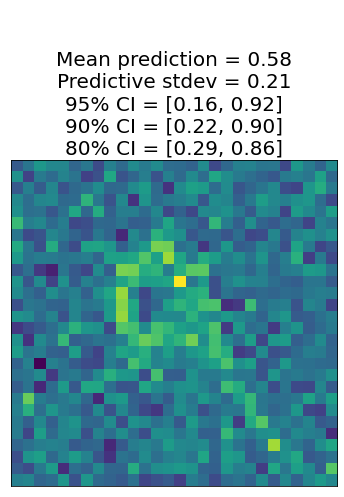

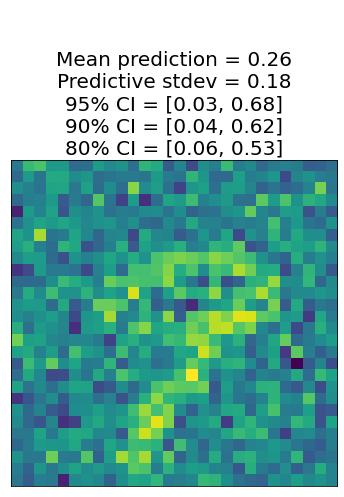

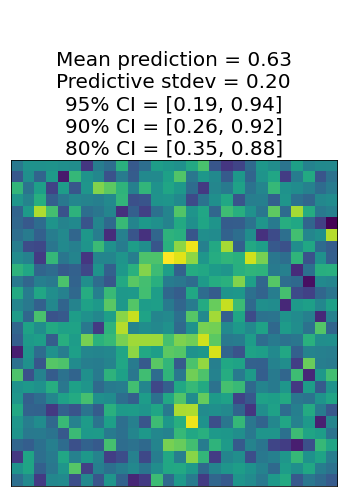

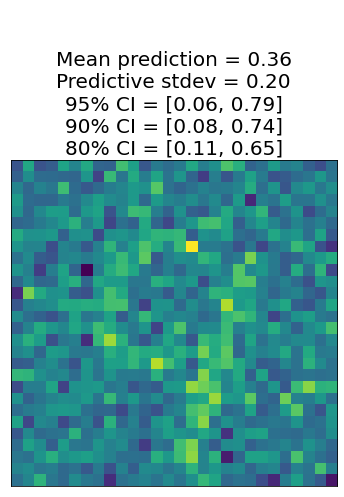

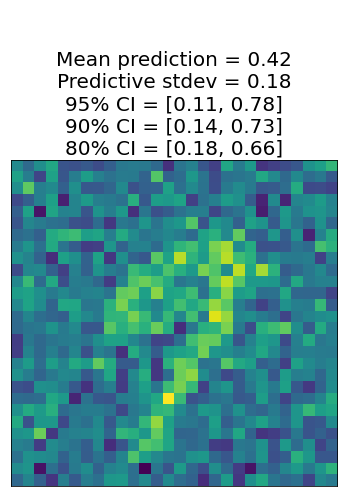

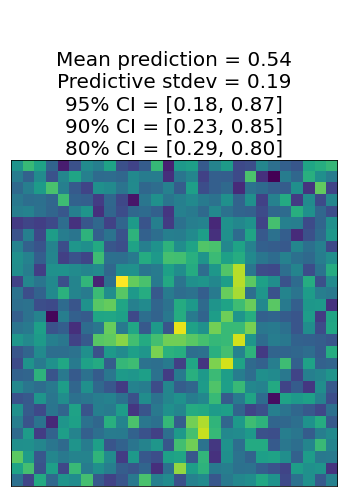

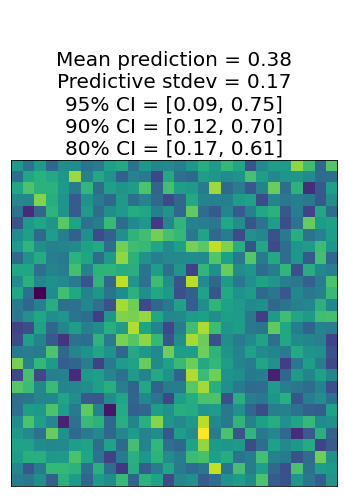

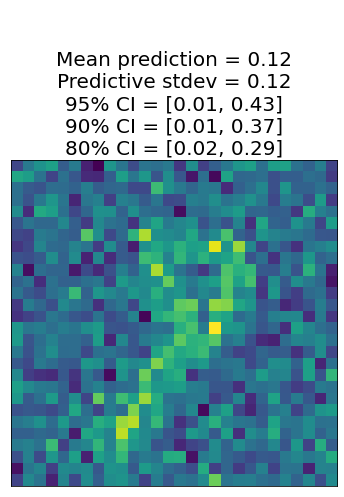

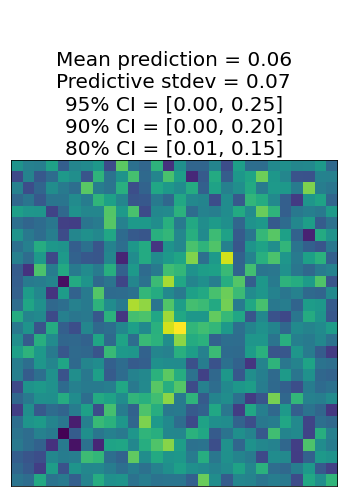

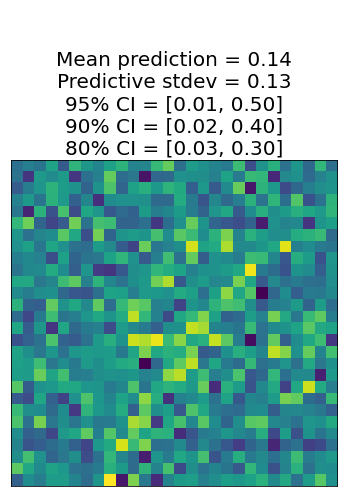

In [ ]:
TOLERANCE = 1e-6

mean_predictions = get_mean_predictions(testing_prediction_matrix_with_bn)
predictive_stdevs = get_predictive_stdevs(testing_prediction_matrix_with_bn)

bottom_predictions_ci95 = numpy.percentile(
    testing_prediction_matrix_with_bn, 2.5, axis=1
)
top_predictions_ci95 = numpy.percentile(
    testing_prediction_matrix_with_bn, 97.5, axis=1
)

bottom_predictions_ci90 = numpy.percentile(
    testing_prediction_matrix_with_bn, 5, axis=1
)
top_predictions_ci90 = numpy.percentile(
    testing_prediction_matrix_with_bn, 95, axis=1
)

bottom_predictions_ci80 = numpy.percentile(
    testing_prediction_matrix_with_bn, 10, axis=1
)
top_predictions_ci80 = numpy.percentile(
    testing_prediction_matrix_with_bn, 90, axis=1
)

positive_target_indices = numpy.where(testing_target_values == 1)[0][:10]

for i in positive_target_indices:
    _, axes_object = pyplot.subplots(
        1, 1, figsize=(6, 6)
    )

    axes_object.imshow(testing_predictor_matrix[i, ..., 0])
    axes_object.set_xticks([])
    axes_object.set_yticks([])

    title_string = (
        '\n\nMean prediction = {0:.2f}\n'
        'Predictive stdev = {1:.2f}\n'
        '95% CI = [{2:.2f}, {3:.2f}]\n'
        '90% CI = [{4:.2f}, {5:.2f}]\n'
        '80% CI = [{6:.2f}, {7:.2f}]'
    ).format(
        mean_predictions[i], predictive_stdevs[i],
        bottom_predictions_ci95[i], top_predictions_ci95[i],
        bottom_predictions_ci90[i], top_predictions_ci90[i],
        bottom_predictions_ci80[i], top_predictions_ci80[i]
    )

    axes_object.set_title(title_string, fontsize=20)

# Objective evaluation

## Spread-skill plot

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Spread-skill reliability = 0.095')

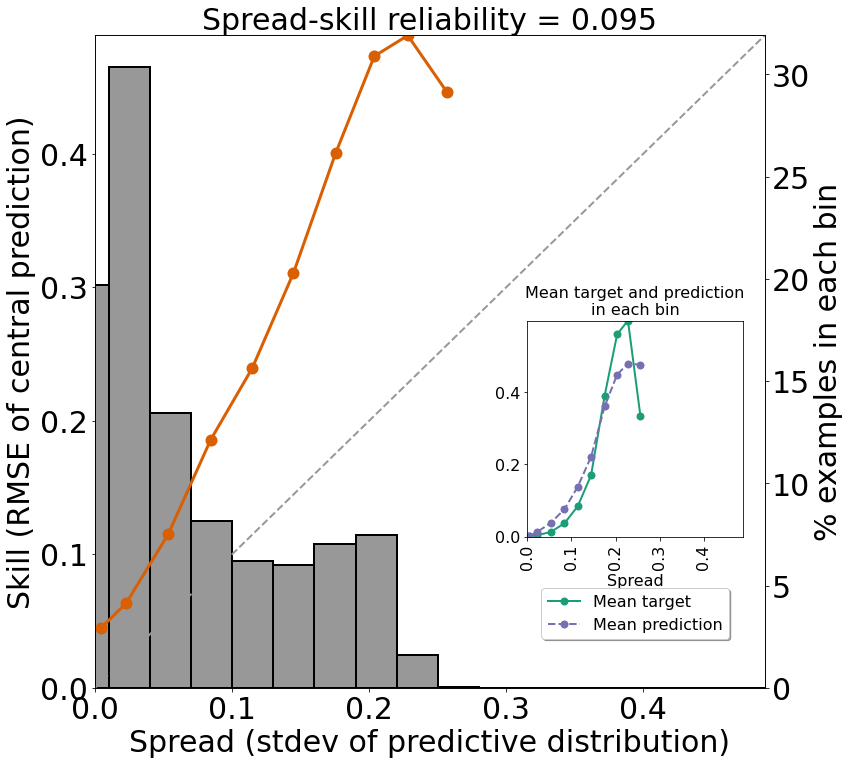

In [ ]:
BIN_EDGE_PREDICTION_STDEVS = numpy.linspace(0.01, 0.61, num=21)

result_dict = get_spread_vs_skill(
    prediction_matrix=testing_prediction_matrix_with_bn,
    target_values=testing_target_values,
    bin_edge_prediction_stdevs=BIN_EDGE_PREDICTION_STDEVS
)

_, axes_object = plot_spread_vs_skill(result_dict)
title_string = 'Spread-skill reliability = {0:.2g}'.format(
    result_dict[SPREAD_SKILL_RELIABILITY_KEY]
)
axes_object.set_title(title_string)

## Discard test

Text(0.5, 1.0, 'Monotonicity fraction = 0.89')

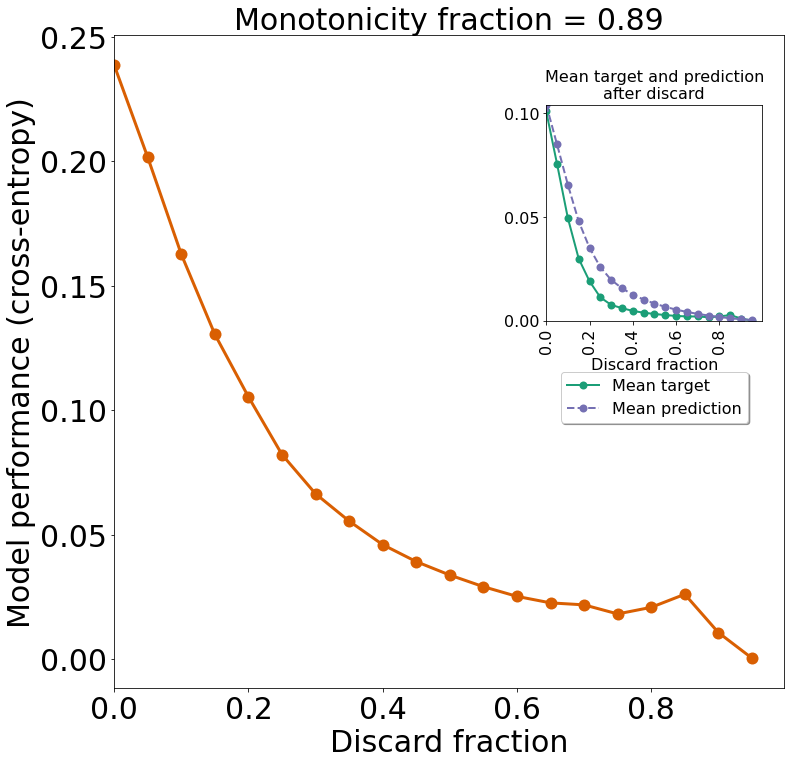

In [ ]:
DISCARD_FRACTIONS = numpy.linspace(0.05, 0.95, num=19)

result_dict = run_discard_test(
    prediction_matrix=testing_prediction_matrix_with_bn,
    target_values=testing_target_values,
    discard_fractions=DISCARD_FRACTIONS
)

_, axes_object = plot_discard_test(result_dict)
title_string = 'Monotonicity fraction = {0:.2f}'.format(
    result_dict[MONOTONICITY_FRACTION_KEY]
)
axes_object.set_title(title_string)

## ROC curve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:451: UserWarning: The following kwargs were not used by contour: 'axes'


Text(0.5, 1.0, 'Area under curve = 0.950')

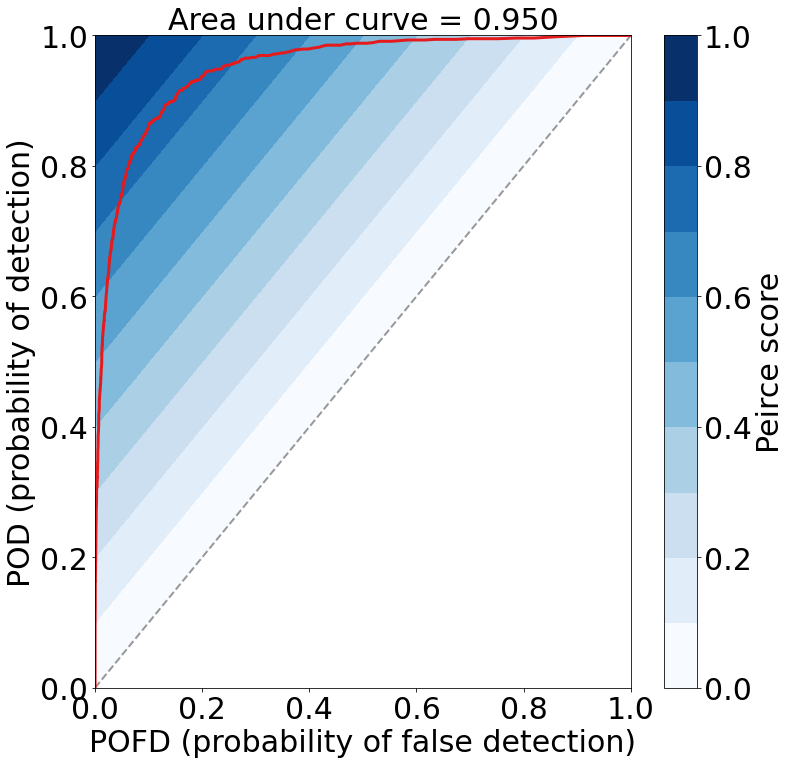

In [ ]:
_, axes_object = pyplot.subplots(
    1, 1, figsize=(12, 12)
)

pofd_by_threshold, pod_by_threshold = plot_roc_curve(
    observed_labels=testing_target_values,
    forecast_probabilities=
    get_mean_predictions(testing_prediction_matrix_with_bn),
    axes_object=axes_object
)

real_indices = numpy.where(numpy.invert(numpy.logical_or(
    numpy.isnan(pofd_by_threshold),
    numpy.isnan(pod_by_threshold),
)))[0]

auc_value = area_under_curve(
    x=pofd_by_threshold[real_indices], y=pod_by_threshold[real_indices]
)

title_string = 'Area under curve = {0:.3f}'.format(auc_value)
axes_object.set_title(title_string)

## Performance diagram

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:545: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:259: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:590: UserWarning: The following kwargs were not used by contour: 'axes'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:610: UserWarning: The following kwargs were not used by contour: 'axes'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:259: RuntimeWarning: divide by zero encountered in reciprocal


Text(0.5, 1.0, 'Max CSI = 0.538')

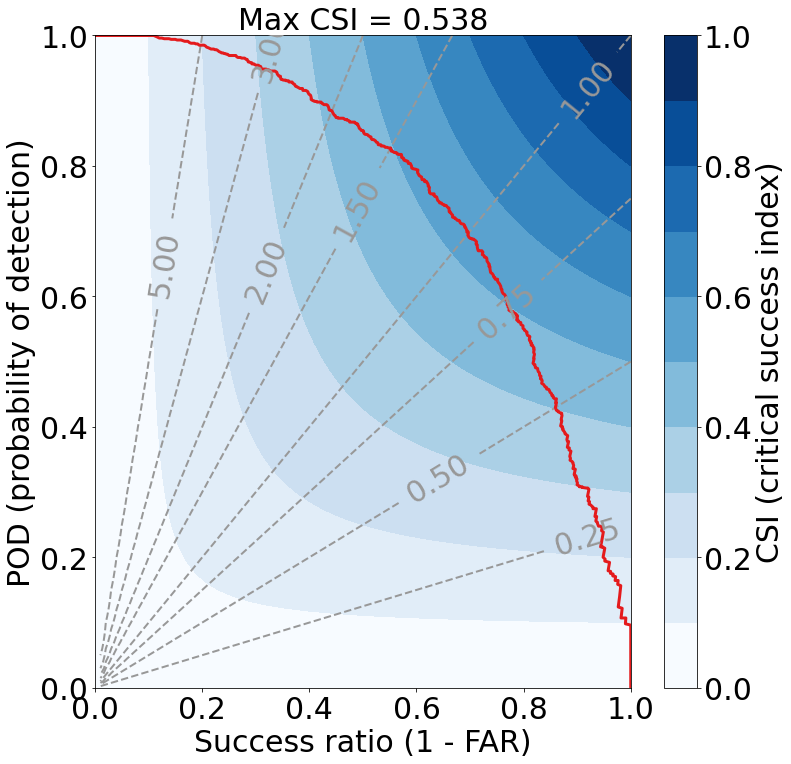

In [ ]:
_, axes_object = pyplot.subplots(
    1, 1, figsize=(12, 12)
)

pod_by_threshold, success_ratio_by_threshold = plot_performance_diagram(
    observed_labels=testing_target_values,
    forecast_probabilities=
    get_mean_predictions(testing_prediction_matrix_with_bn),
    axes_object=axes_object
)

csi_by_threshold = _csi_from_sr_and_pod(
    success_ratio_array=success_ratio_by_threshold,
    pod_array=pod_by_threshold
)

title_string = 'Max CSI = {0:.3f}'.format(numpy.nanmax(csi_by_threshold))
axes_object.set_title(title_string)

## Attributes diagram

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Brier skill score = 0.484')

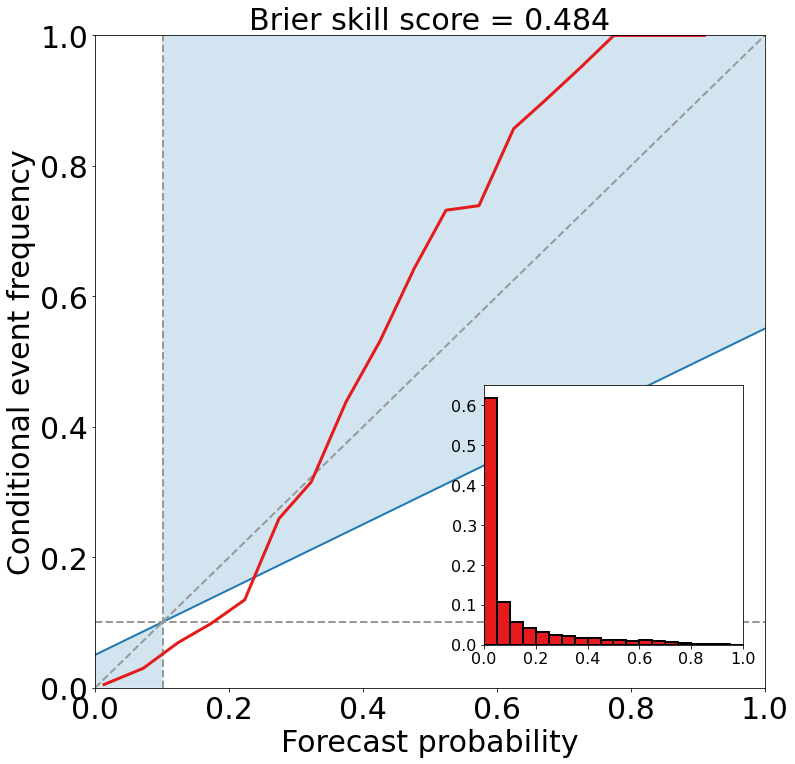

In [ ]:
figure_object, axes_object = pyplot.subplots(
    1, 1, figsize=(12, 12)
)

brier_skill_score = plot_attributes_diagram(
    observed_labels=testing_target_values,
    forecast_probabilities=
    get_mean_predictions(testing_prediction_matrix_with_bn),
    climatology=numpy.mean(training_target_values),
    num_bins=20, figure_object=figure_object, axes_object=axes_object
)[-1]

title_string = 'Brier skill score = {0:.3f}'.format(brier_skill_score)
axes_object.set_title(title_string)